# Alzheimer’s Disease Prediction by Machine Learning Models with MRI Images

## Original Data + GLCM + 4 Folders

### Importing Libraries

In [34]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
import skimage.feature as feature

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

import sys, glob, time,re,string
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0

### Loading The Dataset

Since the dataset consists of lots of MRI images, I decided to upload them by using Kaggle API.

In [3]:
dataset_url = "https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset"
od.download(dataset_url)

Skipping, found downloaded files in "./alzheimer-mri-dataset" (use force=True to force download)


### Dataset Analysis

In [4]:
#Dataset directory
dataset_dir = "./alzheimer-mri-dataset/Dataset"
print(os.listdir(dataset_dir))

files = os.listdir(dataset_dir)
print(f"Number of labels is {len(files)} in this dataset.")

['Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented', 'Non_Demented']
Number of labels is 4 in this dataset.


As we can see there are four groups of images in the dataset such as 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented' and 'Non_Demented'.

In [5]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 896
Number of images in Very_Mild_Demented folder: 2240
Number of images in Non_Demented folder: 3200
Total number of images in the dataset: 6400


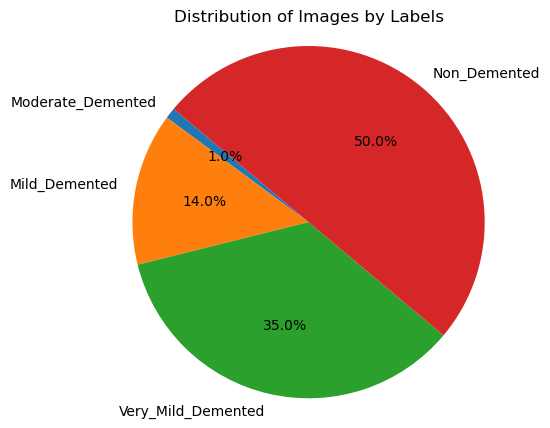

In [6]:
plt.figure(figsize=(5, 5))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images by Labels')
plt.axis('equal')
plt.show()

In [7]:
def visualise_images(path, label, num_samples= 5):
    label_dir = os.path.join(path, label)
    image_files = os.listdir(label_dir)
    random_samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    plt.figure(figsize=(20, 4))
    for i, image_file in enumerate(random_samples):
        img_path = os.path.join(label_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image {i+1}')
        plt.axis('off')
    plt.show()

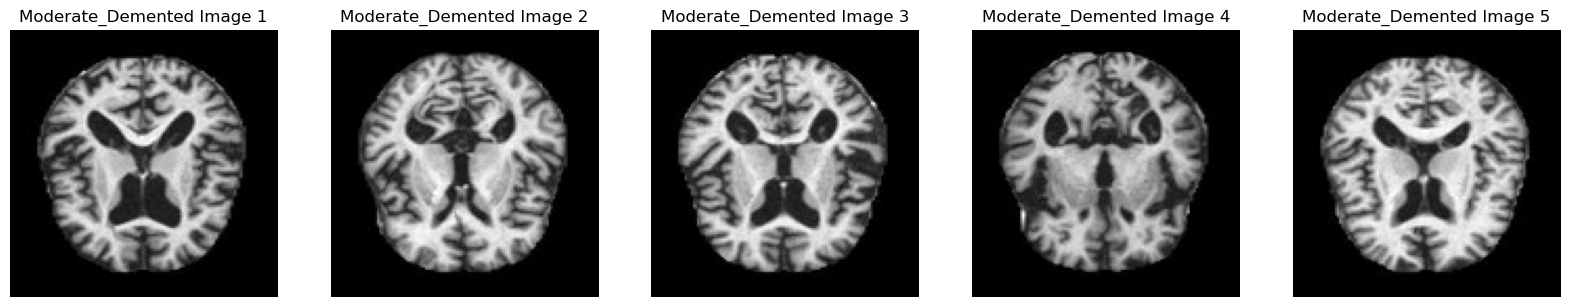

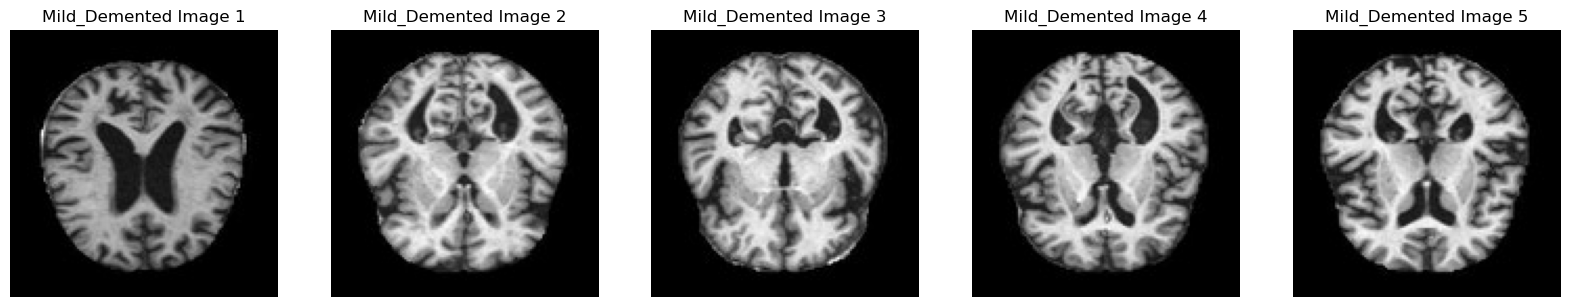

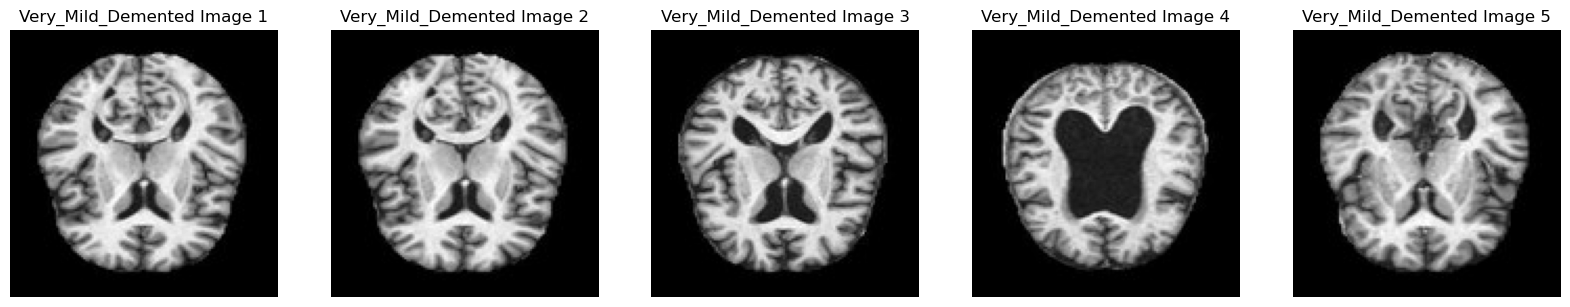

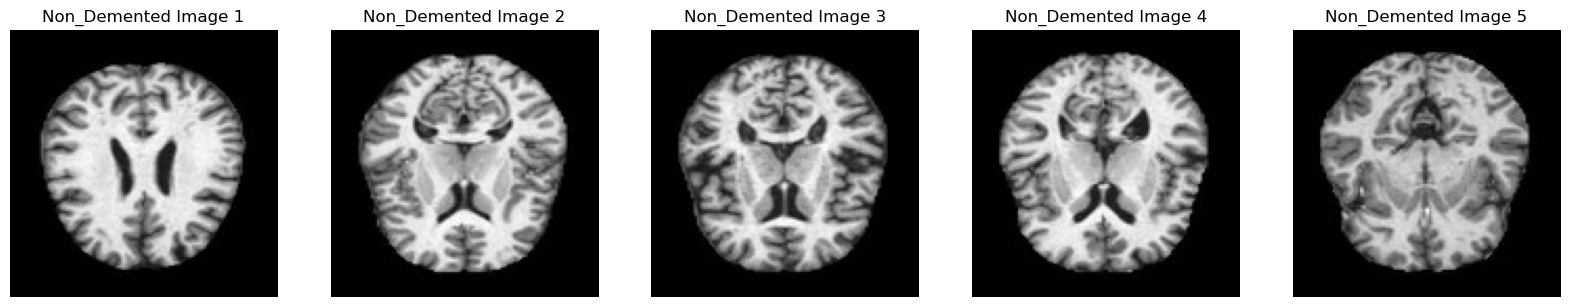

In [8]:
labels = os.listdir(dataset_dir)
for label in labels:
    visualise_images(dataset_dir, label)

### Dataset Preprocessing

#### Resize

Each image in the dataset needs to have the same size—that is, 128 × 128. Even though the images that were chosen randomly have the same size, it is still important to review the data set and make any modifications that are required.

In [9]:
def resize_images(path, label, size=(128,128)):
    label_dir = os.path.join(path, label)
    for image_file in os.listdir(label_dir):
        img_path = os.path.join(label_dir, image_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img.shape != size:
            img_resized = cv2.resize(img, size)
            cv2.imwrite(img_path, img_resized) 

In [10]:
labels = os.listdir(dataset_dir)
for label in labels:
    resize_images(dataset_dir, label)
    if resize_images(dataset_dir, label):
        print(f"Images resized in {label}.")
    else:
        print(f"None of the images needed to be resized in {label}.")

None of the images needed to be resized in Moderate_Demented.
None of the images needed to be resized in Mild_Demented.
None of the images needed to be resized in Very_Mild_Demented.
None of the images needed to be resized in Non_Demented.


In [11]:
#To balance the dataset deleting the images from some folders
def delete_images(label_dir, num_images):
   
    images = os.listdir(label_dir)
    num_images = min(num_images, len(images))

    images_to_delete = random.sample(images, num_images)
    for image in images_to_delete:
        image_path = os.path.join(label_dir, image)
        os.remove(image_path)

non_demented_dir = os.path.join(dataset_dir, "Non_Demented")
very_mild_demented_dir = os.path.join(dataset_dir, "Very_Mild_Demented")
mild_demented_dir = os.path.join(dataset_dir, "Mild_Demented")

num_delete_nd = 2820
num_delete_vmd =1860
num_delete_md = 500
delete_images(non_demented_dir, num_delete_nd)
delete_images(very_mild_demented_dir, num_delete_vmd)
delete_images(mild_demented_dir, num_delete_md)

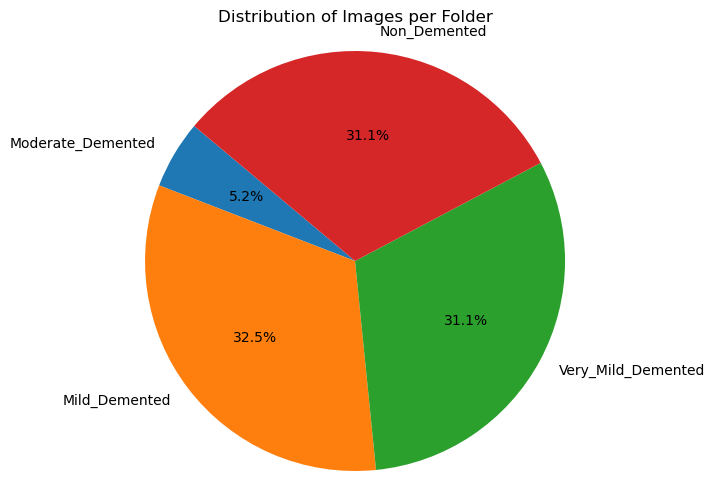

Number of Images in Each Folder:
Moderate_Demented: 64 images
Mild_Demented: 396 images
Very_Mild_Demented: 380 images
Non_Demented: 380 images


In [12]:
folders = os.listdir(dataset_dir)
folder_image_count = {}
for folder in folders:
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        folder_image_count[folder] = len(images)

#distribution using a pie chart
plt.figure(figsize=(8, 6))
plt.pie(folder_image_count.values(), labels=folder_image_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images per Folder')
plt.axis('equal')
plt.show()

print("Number of Images in Each Folder:")
for folder, count in folder_image_count.items():
    print(f"{folder}: {count} images")

In [13]:
total_images = 0
label_counts = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        num_images = len(os.listdir(label_dir))
        total_images += num_images
        label_counts[label] = num_images
        print(f"Number of images in {label} folder: {num_images}")

print(f"Total number of images in the dataset: {total_images}")

Number of images in Moderate_Demented folder: 64
Number of images in Mild_Demented folder: 396
Number of images in Very_Mild_Demented folder: 380
Number of images in Non_Demented folder: 380
Total number of images in the dataset: 1220


### Grey Level Co-occurrence Matrix (GLCM)

In [14]:
#Create dataframe from the dataset
def create_dataframe(dataset_dir):
    data = []
    for label in os.listdir(dataset_dir):
        label_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                data.append({'image_path': image_path, 'label': label})
    df = pd.DataFrame(data)
    return df

In [15]:
dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm

,image_path,label
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented
...,...,...
1215,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
1216,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
1217,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented
1218,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented


In [16]:
#Function for calculate GLCM features
def calculate_glcm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

    #properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return contrast, dissimilarity, homogeneity, energy, correlation

In [17]:
def df_with_glcm(df):

    glcm_properties = df['image_path'].apply(calculate_glcm)
    df[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']] = pd.DataFrame(glcm_properties.tolist(), index=df.index)
    return df

dataset_dir = "./alzheimer-mri-dataset/Dataset"
df_glcm = create_dataframe(dataset_dir)
df_glcm = df_with_glcm(df_glcm)
df_glcm

,image_path,label,contrast,dissimilarity,homogeneity,energy,correlation
0,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,383.053888,10.333415,0.474799,0.414340,0.969073
1,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,384.702510,10.571727,0.457372,0.396913,0.968889
2,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,368.517470,10.687992,0.450977,0.392511,0.975163
3,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,336.392840,10.031496,0.469532,0.407312,0.978389
4,./alzheimer-mri-dataset/Dataset/Moderate_Demen...,Moderate_Demented,355.734375,10.418922,0.457106,0.395116,0.975453
...,...,...,...,...,...,...,...
1215,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,310.265010,9.018824,0.478847,0.409313,0.981810
1216,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,317.840059,9.385458,0.471634,0.409150,0.980493
1217,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,355.366880,9.789493,0.456729,0.390447,0.974058
1218,./alzheimer-mri-dataset/Dataset/Non_Demented/n...,Non_Demented,343.651575,9.943159,0.450167,0.388850,0.977299


In [18]:
X = df_glcm.iloc[:,2:7]
y = df_glcm['label']

X

,contrast,dissimilarity,homogeneity,energy,correlation
0,383.053888,10.333415,0.474799,0.414340,0.969073
1,384.702510,10.571727,0.457372,0.396913,0.968889
2,368.517470,10.687992,0.450977,0.392511,0.975163
3,336.392840,10.031496,0.469532,0.407312,0.978389
4,355.734375,10.418922,0.457106,0.395116,0.975453
...,...,...,...,...,...
1215,310.265010,9.018824,0.478847,0.409313,0.981810
1216,317.840059,9.385458,0.471634,0.409150,0.980493
1217,355.366880,9.789493,0.456729,0.390447,0.974058
1218,343.651575,9.943159,0.450167,0.388850,0.977299


In [20]:
#Machine Learning function
def ml_models(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

# Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    classification = classification_report(y_test, y_pred, zero_division=1)
    print("classification_report:", classification)

In [21]:
#RANDOM FOREST
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10)
ml_models(rf_model, X, y)

Accuracy: 0.5450819672131147
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.54      0.76      0.63        85
 Moderate_Demented       0.17      0.08      0.11        12
      Non_Demented       0.66      0.55      0.60        77
Very_Mild_Demented       0.46      0.36      0.40        70

          accuracy                           0.55       244
         macro avg       0.46      0.44      0.44       244
      weighted avg       0.54      0.55      0.53       244



In [22]:
#GAUSSIAN NB
gnb_model = GaussianNB()
ml_models(gnb_model, X, y)

Accuracy: 0.4344262295081967
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.41      0.72      0.52        85
 Moderate_Demented       1.00      0.00      0.00        12
      Non_Demented       0.50      0.57      0.53        77
Very_Mild_Demented       0.12      0.01      0.03        70

          accuracy                           0.43       244
         macro avg       0.51      0.33      0.27       244
      weighted avg       0.39      0.43      0.36       244



In [23]:
#DECISION TREE
dt_model = DecisionTreeClassifier()
ml_models(dt_model, X, y)

Accuracy: 0.47540983606557374
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.48      0.54      0.51        85
 Moderate_Demented       0.42      0.42      0.42        12
      Non_Demented       0.56      0.55      0.55        77
Very_Mild_Demented       0.37      0.33      0.35        70

          accuracy                           0.48       244
         macro avg       0.46      0.46      0.46       244
      weighted avg       0.47      0.48      0.47       244



In [24]:
#SVM
svm_model = SVC(kernel='linear', random_state=42)
ml_models(svm_model, X, y)

Accuracy: 0.4098360655737705
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.41      0.68      0.51        85
 Moderate_Demented       1.00      0.00      0.00        12
      Non_Demented       0.43      0.40      0.42        77
Very_Mild_Demented       0.35      0.16      0.22        70

          accuracy                           0.41       244
         macro avg       0.55      0.31      0.29       244
      weighted avg       0.43      0.41      0.37       244



In [25]:
#LOGISTIC REGRESSION
lr_model = LogisticRegression(max_iter=1000, random_state=42)
ml_models(lr_model, X, y)

Accuracy: 0.4139344262295082
classification_report:                     precision    recall  f1-score   support

     Mild_Demented       0.41      0.65      0.50        85
 Moderate_Demented       1.00      0.00      0.00        12
      Non_Demented       0.45      0.42      0.43        77
Very_Mild_Demented       0.35      0.20      0.25        70

          accuracy                           0.41       244
         macro avg       0.55      0.32      0.30       244
      weighted avg       0.44      0.41      0.39       244



In [26]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(128,128)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

In [27]:
#Train data
Images, Labels = get_images("./alzheimer-mri-dataset/Dataset/") #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [28]:
label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(Labels)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

In [30]:
from collections import Counter
Counter(encoded_labels)

Counter({0: 396, 2: 380, 3: 380, 1: 64})

### Deep Learning

In [31]:
#Function for deep learning approaches
def deep_learning(base_model, input_shape=(128, 128, 3), num_classes=4):
    model = Sequential()
    model.add(base_model(include_top=False, weights='imagenet', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.layers[0].trainable = False
    return model

In [32]:
#EfficientNetB0
efficientnet_model = deep_learning(EfficientNetB0)
efficientnet_model.summary()

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_eff = efficientnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 4096)              83890176  
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2

Epoch 1/100


2024-06-05 14:01:30.019811: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


31/31 [==============================] - 11s 307ms/step - loss: 1.2742 - accuracy: 0.4047 - val_loss: 1.2064 - val_accuracy: 0.4098
Epoch 2/100
31/31 [==============================] - 8s 258ms/step - loss: 1.1086 - accuracy: 0.4805 - val_loss: 1.1854 - val_accuracy: 0.4303
Epoch 3/100
31/31 [==============================] - 8s 258ms/step - loss: 1.0900 - accuracy: 0.4846 - val_loss: 1.2037 - val_accuracy: 0.3893
Epoch 4/100
31/31 [==============================] - 8s 257ms/step - loss: 1.0147 - accuracy: 0.5195 - val_loss: 1.1525 - val_accuracy: 0.4836
Epoch 5/100
31/31 [==============================] - 8s 252ms/step - loss: 0.9596 - accuracy: 0.5676 - val_loss: 1.0561 - val_accuracy: 0.4508
Epoch 6/100
31/31 [==============================] - 8s 270ms/step - loss: 0.9134 - accuracy: 0.5932 - val_loss: 1.0452 - val_accuracy: 0.5041
Epoch 7/100
31/31 [==============================] - 8s 255ms/step - loss: 0.8327 - accuracy: 0.6148 - val_loss: 0.9675 - val_accuracy: 0.6148
Epoch 8/10

In [35]:
# Predicting and Evaluating the model
y_pred = np.argmax(efficientnet_model.predict(X_test), axis=1)

# Evaluating the model with F1, recall, and precision
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

8/8 [==============================] - 1s 125ms/step
F1 Score: 0.7902746496145978
Recall: 0.7909836065573771
Precision: 0.7904297740363313
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81        70
           1       0.94      1.00      0.97        16
           2       0.79      0.75      0.77        72
           3       0.76      0.76      0.76        86

    accuracy                           0.79       244
   macro avg       0.82      0.83      0.83       244
weighted avg       0.79      0.79      0.79       244



In [36]:
#VGG16
vgg_model = deep_learning(VGG16)
vgg_model.summary()

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 4096)              33558528  
                                                                 
 dense_7 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 32)               

Epoch 1/100
31/31 [==============================] - 35s 1s/step - loss: 1.7196 - accuracy: 0.3863 - val_loss: 1.2215 - val_accuracy: 0.4672
Epoch 2/100
31/31 [==============================] - 38s 1s/step - loss: 1.0360 - accuracy: 0.5615 - val_loss: 1.1907 - val_accuracy: 0.4754
Epoch 3/100
31/31 [==============================] - 36s 1s/step - loss: 0.7589 - accuracy: 0.6865 - val_loss: 0.9324 - val_accuracy: 0.5943
Epoch 4/100
31/31 [==============================] - 35s 1s/step - loss: 0.5133 - accuracy: 0.8217 - val_loss: 0.9314 - val_accuracy: 0.6393
Epoch 5/100
31/31 [==============================] - 35s 1s/step - loss: 0.3746 - accuracy: 0.8740 - val_loss: 0.8262 - val_accuracy: 0.6721
Epoch 6/100
31/31 [==============================] - 35s 1s/step - loss: 0.3136 - accuracy: 0.8904 - val_loss: 0.8162 - val_accuracy: 0.6803
Epoch 7/100
31/31 [==============================] - 35s 1s/step - loss: 0.1880 - accuracy: 0.9477 - val_loss: 0.8336 - val_accuracy: 0.6967
Epoch 8/100
3

In [37]:
# Predicting and Evaluating the model
y_pred = np.argmax(vgg_model.predict(X_test), axis=1)

# Evaluating the model with F1, recall, and precision
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

8/8 [==============================] - 7s 833ms/step
F1 Score: 0.7514055150984456
Recall: 0.7540983606557377
Precision: 0.7553532268683013
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.89      0.81        70
           1       1.00      0.88      0.93        16
           2       0.74      0.75      0.74        72
           3       0.73      0.63      0.68        86

    accuracy                           0.75       244
   macro avg       0.80      0.78      0.79       244
weighted avg       0.76      0.75      0.75       244



In [38]:
#ResNet50
resnet_model = deep_learning(ResNet50)
resnet_model.summary()

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 4096)              134221824 
                                                                 
 dense_13 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_14 (Dense)            (None, 256)               262400    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 32)               

Epoch 1/100
31/31 [==============================] - 24s 749ms/step - loss: 1.5946 - accuracy: 0.3514 - val_loss: 1.2886 - val_accuracy: 0.4098
Epoch 2/100
31/31 [==============================] - 22s 706ms/step - loss: 1.1082 - accuracy: 0.4734 - val_loss: 1.1268 - val_accuracy: 0.4385
Epoch 3/100
31/31 [==============================] - 26s 855ms/step - loss: 0.9175 - accuracy: 0.5963 - val_loss: 1.0650 - val_accuracy: 0.5123
Epoch 4/100
31/31 [==============================] - 25s 810ms/step - loss: 0.8852 - accuracy: 0.6260 - val_loss: 1.1862 - val_accuracy: 0.4631
Epoch 5/100
31/31 [==============================] - 26s 848ms/step - loss: 0.7597 - accuracy: 0.6824 - val_loss: 1.1300 - val_accuracy: 0.4918
Epoch 6/100
31/31 [==============================] - 26s 856ms/step - loss: 0.7892 - accuracy: 0.6609 - val_loss: 1.5147 - val_accuracy: 0.4549
Epoch 7/100
31/31 [==============================] - 26s 853ms/step - loss: 0.6872 - accuracy: 0.7029 - val_loss: 0.9303 - val_accuracy:

In [39]:
# Predicting and Evaluating the model
y_pred = np.argmax(resnet_model.predict(X_test), axis=1)

# Evaluating the model with F1, recall, and precision
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

8/8 [==============================] - 3s 323ms/step
F1 Score: 0.7214046014072042
Recall: 0.7254098360655737
Precision: 0.7210898302328059
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78        70
           1       1.00      1.00      1.00        16
           2       0.74      0.76      0.75        72
           3       0.64      0.56      0.60        86

    accuracy                           0.73       244
   macro avg       0.78      0.79      0.78       244
weighted avg       0.72      0.73      0.72       244

